# Setup and Load Data

### Installing dependencies and Setup

In [1]:
!pip install tensorflow opencv-python matplotlib

In [2]:
!pip list

Package                           Version
--------------------------------- ------------------
absl-py                           2.1.0
aiobotocore                       2.12.3
aiohttp                           3.9.5
aioitertools                      0.7.1
aiosignal                         1.2.0
alabaster                         0.7.16
altair                            5.0.1
anaconda-anon-usage               0.4.4
anaconda-catalogs                 0.2.0
anaconda-client                   1.12.3
anaconda-cloud-auth               0.5.1
anaconda-navigator                2.6.0
anaconda-project                  0.11.1
annotated-types                   0.6.0
anyio                             4.2.0
appdirs                           1.4.4
archspec                          0.2.3
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
arrow                             1.2.3
astroid                           2.14.2
astropy                           6.1.0
astropy-iers-data 

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM error by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.configure.experimental.set_memory_growth(gpu, True)

### Remove dodgy images

In [5]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [6]:
data_dir = "data"

In [7]:
image_exist = ["jpeg", "jpg", "png", "bmp"]

In [8]:
img = cv2.imread(os.path.join("data", "happy", "MensHealth.jpeg"))

In [9]:
img.shape

(3648, 5472, 3)

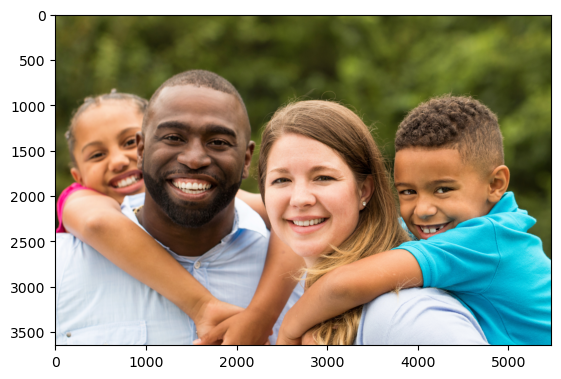

In [10]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [11]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = (Image.open(image_path).format).lower()
            if tip not in image_exist:
                print("Image not in exist list {}".format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("Issue with image {}".format(image_path))

Issue with image data\happy\kiGH9ukZK6Q4hvtDtwwVc1yvueg.svg
Issue with image data\happy\vector.svg
Issue with image data\happy\vector2.svg
Issue with image data\happy\vector3.svg
Issue with image data\happy\vector4.svg
Issue with image data\happy\vector5.svg
Issue with image data\happy\vector6.svg
Issue with image data\happy\vector7.svg
Issue with image data\sad\kiGH9ukZK6Q4hvtDtwwVc1yvueg.svg
Issue with image data\sad\vector.svg
Issue with image data\sad\vector2.svg
Issue with image data\sad\vector3.svg
Issue with image data\sad\vector4.svg
Issue with image data\sad\vector5.svg
Issue with image data\sad\vector6.svg
Issue with image data\sad\vector7.svg


In [12]:
tf.data.Dataset??

Init signature: tf.data.Dataset(variant_tensor)
Source:        
@tf_export("data.Dataset", v1=[])
class DatasetV2(
    collections_abc.Iterable,
    tracking_base.Trackable,
    composite_tensor.CompositeTensor,
    data_types.DatasetV2,
    metaclass=abc.ABCMeta):
  """Represents a potentially large set of elements.

  The `tf.data.Dataset` API supports writing descriptive and efficient input
  pipelines. `Dataset` usage follows a common pattern:

  1. Create a source dataset from your input data.
  2. Apply dataset transformations to preprocess the data.
  3. Iterate over the dataset and process the elements.

  Iteration happens in a streaming fashion, so the full dataset does not need to
  fit into memory.

  Source Datasets:

  The simplest way to create a dataset is to create it from a python `list`:

  >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
  >>> for element in dataset:
  ...   print(element)
  tf.Tensor(1, shape=(), dtype=int32)
  tf.Tensor(2, shape=(), dty

In [13]:
import numpy as np

In [14]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 327 files belonging to 2 classes.


In [15]:
data_iterator = data.as_numpy_iterator()

In [16]:
batch = data_iterator.next()

In [17]:
batch[0].shape

(32, 256, 256, 3)

In [18]:
# Class 0 = happy, CLass 1 = sad
batch[1]

array([0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0])

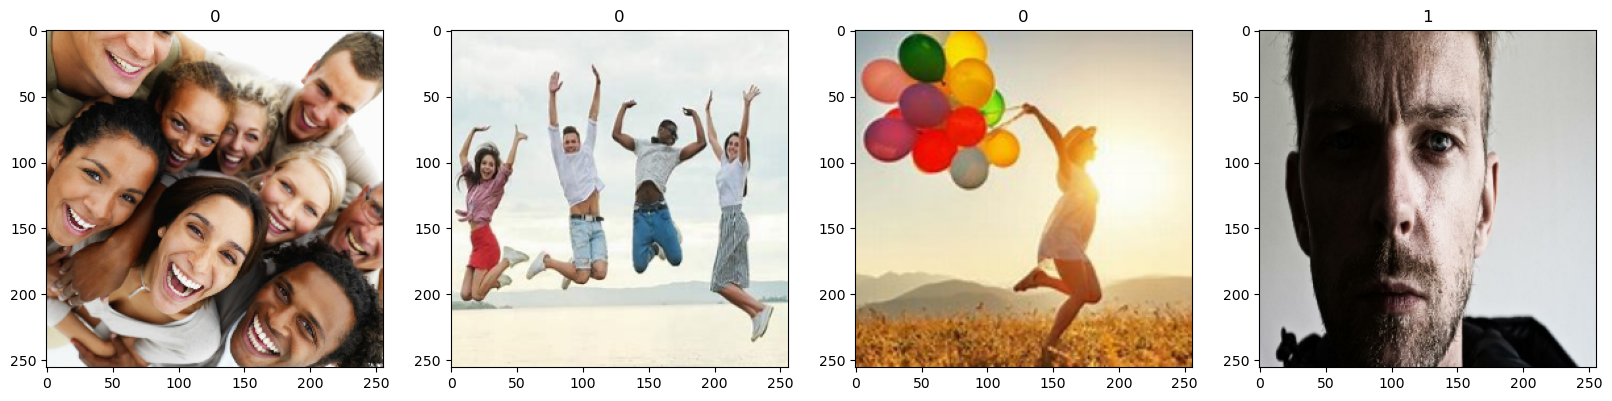

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Preprocessing Data

### Scale Data

In [20]:
data = data.map(lambda x, y: (x/255, y))

In [21]:
scaled_iterator = data.as_numpy_iterator()

In [22]:
batch = scaled_iterator.next()

In [23]:
batch[0].max()

1.0

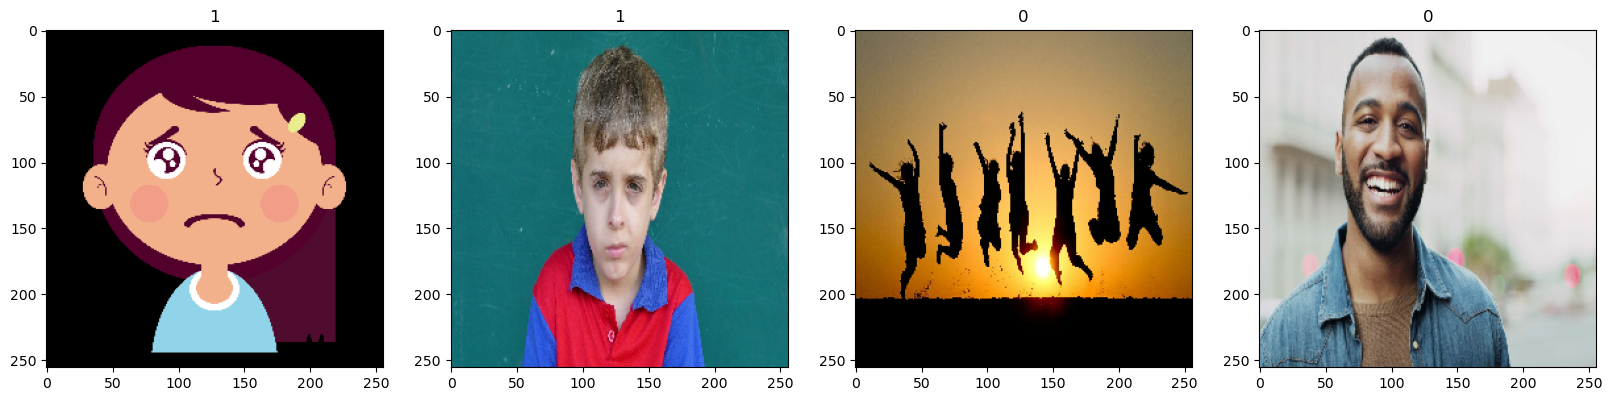

In [24]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [25]:
len(data)

11

In [26]:
train_size = int(len(data) * .7)
val_size = int(len(data) * .2)+1
test_size = int(len(data) * .1)

In [27]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# Deep Model

### Build Deep Learning Model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input

In [29]:
model = Sequential()

In [30]:
model.add(Input(shape=(256,256,3)))

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [31]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

### Train

In [33]:
logdir = 'logs'

In [34]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [35]:
hist = model.fit(train, epochs=20, validation_data = val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 244ms/step - accuracy: 0.5295 - loss: 0.9693 - val_accuracy: 0.6042 - val_loss: 0.6651
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - accuracy: 0.5601 - loss: 0.6601 - val_accuracy: 0.6875 - val_loss: 0.5858
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - accuracy: 0.6935 - loss: 0.6622 - val_accuracy: 0.5833 - val_loss: 0.5856
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - accuracy: 0.6027 - loss: 0.6140 - val_accuracy: 0.6458 - val_loss: 0.5434
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - accuracy: 0.6903 - loss: 0.5355 - val_accuracy: 0.8125 - val_loss: 0.4608
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.8072 - loss: 0.4264 - val_accuracy: 0.8021 - val_loss: 0.3368
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.8224 - loss: 0.3224 - val_accuracy: 0.8854 - val_loss: 0.2555
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - accuracy: 0.8827 - loss: 0.2531 - val_accuracy: 0.9167 - val_loss:

### Plot Performance

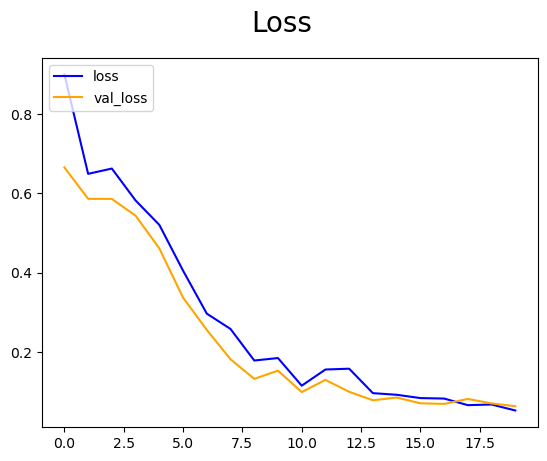

In [36]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='blue', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

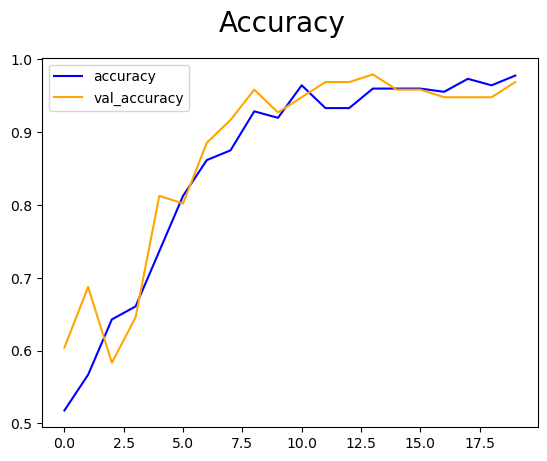

In [37]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='blue', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluation Performance

### Evaluate

In [38]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [39]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [40]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yHat = model.predict(X)
    pre.update_state(y, yHat)
    re.update_state(y, yHat)
    acc.update_state(y, yHat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


In [41]:
print(f"Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}")

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


### Test

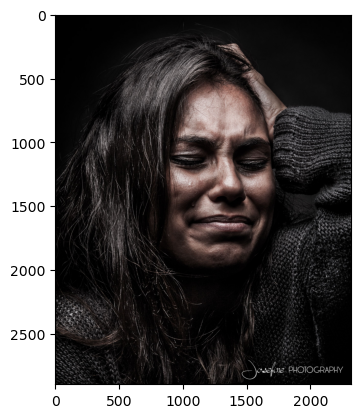

In [65]:
# for checking random image
img = cv2.imread('sad_test2.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

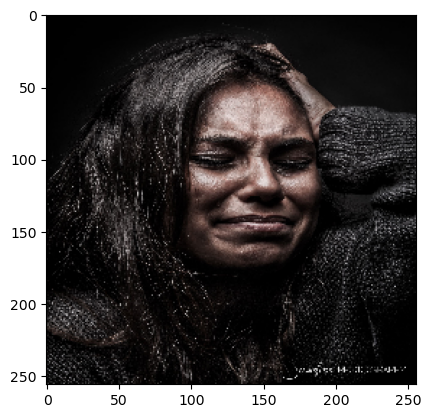

In [66]:
resize = tf.image.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [67]:
np.expand_dims(resize,0).shape

(1, 256, 256, 3)

In [68]:
yHat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [69]:
yHat

array([[0.99999243]], dtype=float32)

In [70]:
if yHat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad
